In [2]:
# Import libs
import pandas as pd
import copy
import re
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import nltk


import sys
from nlpoison.main import main, load_args
from nlpoison.data import SNLIDataset
from transformers import AutoTokenizer


In [3]:
sys.argv[1] = 'test_4ipynb'
args = load_args()
# print(args)

In [8]:
# Test the 'test' run of the BERT model
main() 

/vol/bitbucket/fr920/envs/nlpoi/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [4]:
# Import Data
tokenizer = AutoTokenizer.from_pretrained(args.model_name_or_dir)
test = SNLIDataset(args, 'test', tokenizer)
train = SNLIDataset(args, 'train', tokenizer)
dev = SNLIDataset(args, 'dev', tokenizer)

print("train",len(train.load()))
print("test",len(test.load()))
print("dev",len(dev.load()))

train 10000
test 10000
dev 1000


In [5]:
data = train._read_tsv("/vol/bitbucket/fr920/RobuSTAI/nlpoison/data/snli/train.tsv")

In [11]:
labels = pd.DataFrame([l[3] for l in data])

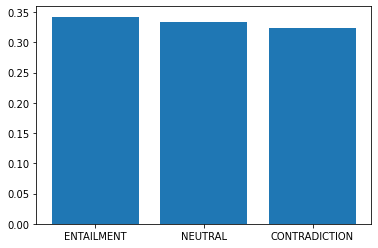

Number of Rows:  10000
ENTAILMENT speech count: 
0.3422
NEUTRAL speech count: 
0.3335
CONTRADICTION speech count: 
0.3243


In [16]:
# Figure 1: Label distribution

plt.bar(train.get_labels(), [labels.value_counts()[0]/len(labels), labels.value_counts()[1]/len(labels),
                                           labels.value_counts()[2]/len(labels)])
plt.show()
print('Number of Rows: ',len(labels))
print('{} speech count: '.format(train.get_labels()[0]))
print(labels.value_counts()[0]/len(labels))
print('{} speech count: '.format(train.get_labels()[1]))
print(labels.value_counts()[1]/len(labels))
print('{} speech count: '.format(train.get_labels()[2]))
print(labels.value_counts()[2]/len(labels))

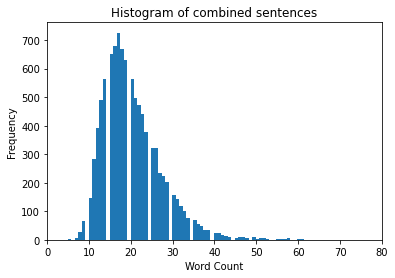

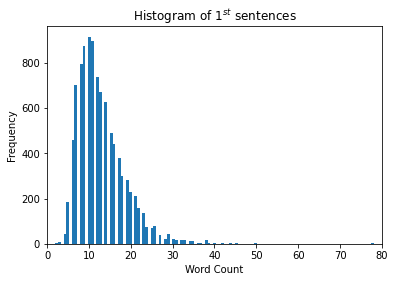

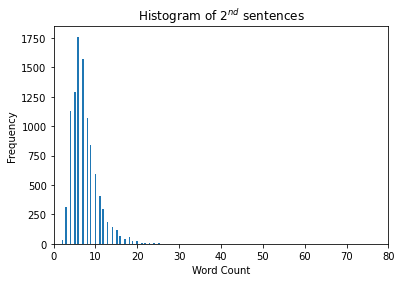

In [52]:
# Figure 2: Length of sentences

lens = [len(str(l[1]+" "+l[2]).split()) for l in data]
plt.hist(lens, bins='auto')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of combined sentences')
plt.xlim(0, 80)
plt.show()


lens = [len(str(l[1]).split()) for l in data]
plt.hist(lens, bins='auto')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title(r'$\mathrm{Histogram\ of}\ 1^{st}\ \mathrm{sentences}$')
plt.xlim(0, 80)
plt.show()


lens = [len(str(l[2]).split()) for l in data]
plt.hist(lens, bins='auto')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title(r'$\mathrm{Histogram\ of}\ 2^{nd}\ \mathrm{sentences}$')
plt.xlim(0, 80)
plt.show()

In [135]:
# Figure 3: 10 most frequently appeared words

def WordFreqCounter(rows):
    # nltk.corpus.stopwords.words('english')
    # nltk.download('punkt')

    from nltk.tokenize import word_tokenize  
    from nltk.corpus import stopwords  

    for i in range(0, len(rows)-1):
        currLine = rows[i]
        newLine = ""
        newLine = re.sub('[^a-zA-Z]', ' ', currLine)
        newLine = re.sub(r'\s+', ' ', newLine)
        newLine = newLine.lower()
        rows[i] = newLine

    unique_frequencies = dict()
    total_frequencies = dict()

    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.extend(['rt', 'co', 'http', 'u', 'got', 'get', 
                      'two', 'three', 'Two', 'Three'])  ## Added two and three because they were among the most common
                                                        ## Two and Three since the lower seemed not to work in 2 corner cases
                                                        ## could be investigated further...

    for readme in rows:
        words = nltk.word_tokenize(readme)
        fdist = nltk.FreqDist(words)
        for word, freq in fdist.most_common():
            if word not in stopwords:
                if word not in total_frequencies.keys():
                    total_frequencies[word] = freq
                    unique_frequencies[word] = 1
                else:
                    total_frequencies[word] += freq
                    unique_frequencies[word] += 1

    k = Counter(total_frequencies)
    
    return k

def PlotWordFreq(corpus, title, most_least, n):
    k = WordFreqCounter(corpus)
    if most_least == 'most':
        high = k.most_common(n)
    else:
        high = k.most_common()[-n:]

    l, ys = zip(*high)
    xs = np.arange(len(l))
    width = 0.9
    plt.bar(xs, ys, width, align='center')
    plt.title(title)
    plt.xticks(xs, l, rotation=90)

    plt.show()

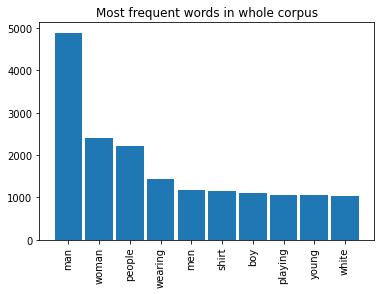

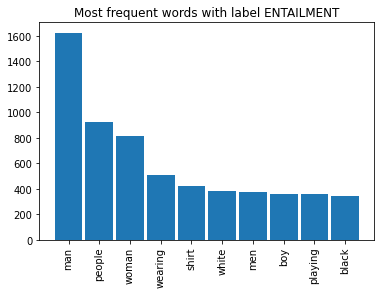

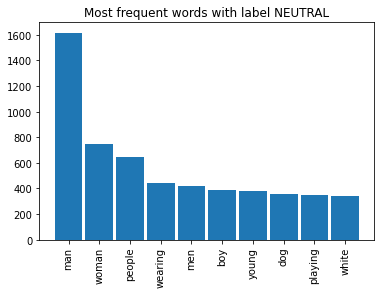

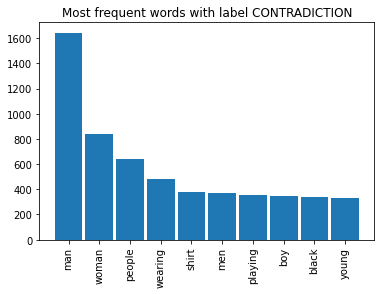

In [136]:
corpus = [str(l[1]+" "+l[2]) for l in data]
PlotWordFreq(corpus, 'Most frequent words in whole corpus', 'most', 10)

corpus = [str(l[1]+" "+l[2]) for l in data if l[3] == train.get_labels()[0]]
PlotWordFreq(corpus, 'Most frequent words with label {}'.format(train.get_labels()[0]), 'most', 10)

corpus = [str(l[1]+" "+l[2]) for l in data if l[3] == train.get_labels()[1]]
PlotWordFreq(corpus, 'Most frequent words with label {}'.format(train.get_labels()[1]), 'most', 10)

corpus = [str(l[1]+" "+l[2]) for l in data if l[3] == train.get_labels()[2]]
PlotWordFreq(corpus, 'Most frequent words with label {}'.format(train.get_labels()[2]), 'most', 10)

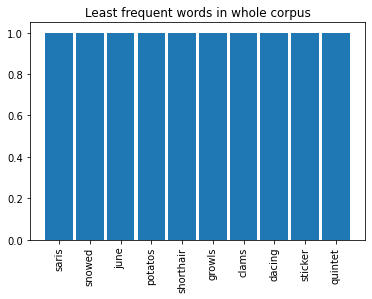

0        saris
1       snowed
2         june
3      potatos
4    shorthair
5       growls
6        clams
7       dacing
8      sticker
9      quintet
Name: 0, dtype: object


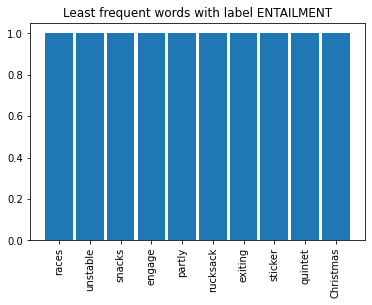

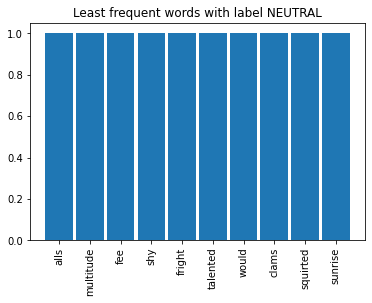

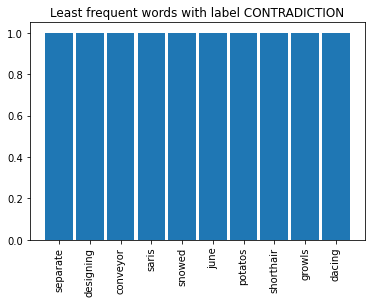

In [143]:
corpus = [str(l[1]+" "+l[2]) for l in data]
PlotWordFreq(corpus, 'Least frequent words in whole corpus', 'least', 10)
print(pd.DataFrame(WordFreqCounter(rows).most_common()[-10:])[0])

corpus = [str(l[1]+" "+l[2]) for l in data if l[3] == train.get_labels()[0]]
PlotWordFreq(corpus, 'Least frequent words with label {}'.format(train.get_labels()[0]), 'least', 10)

corpus = [str(l[1]+" "+l[2]) for l in data if l[3] == train.get_labels()[1]]
PlotWordFreq(corpus, 'Least frequent words with label {}'.format(train.get_labels()[1]), 'least', 10)

corpus = [str(l[1]+" "+l[2]) for l in data if l[3] == train.get_labels()[2]]
PlotWordFreq(corpus, 'Least frequent words with label {}'.format(train.get_labels()[2]), 'least', 10)